In [6]:
%pip install wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
keras = tf.keras
from keras import Input, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, Dropout, Embedding, GRU, Bidirectional, BatchNormalization
from wordcloud import WordCloud
from collections import Counter
import csv
import math
import numpy as np
import pandas as pd
import re
import string
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from functools import lru_cache
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences



Note: you may need to restart the kernel to use updated packages.


In [7]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /home/mca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Q1)

In [8]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
val_df = pd.read_csv("Valid.csv")
train_df.head(3)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


In [9]:
train_df.shape


(40000, 2)

In [10]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [11]:
train_df.duplicated().sum()


277

In [12]:
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
val_df = val_df.drop_duplicates()
train_df.shape


(39723, 2)

In [13]:
VOCAB_SIZE = 10000
MAX_LENGTH = 200
OUTPUT_DIM = 128


In [14]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")


In [15]:
@lru_cache(maxsize=None)
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub('\[.*?\]', "", text)
    text = re.sub('\\W', " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub('<.*?>+', "", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), "", text)
    text = re.sub('\n', "", text)
    text = re.sub('\w*\d\w*', "", text)

    return text


In [16]:
stop_words = set(stopwords.words('english'))
stop_words.add("br")

@lru_cache(maxsize=None)
def tokenize_and_lemmatize(text: str) -> [str]:
    tokens = word_tokenize(text)
    stemmed = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return " ".join(stemmed)


In [17]:
train_df.iloc[:, 0] = train_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
train_df.head(3)


,text,label
0,grew b watching loving thunderbird mate school...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0


In [18]:
test_df.iloc[:, 0] = test_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
test_df.head(3)


,text,label
0,always wrote series complete stink fest jim be...,0
1,watched dir steve purcell typical mary kate as...,0
2,movie poorly written directed fell asleep minu...,0


In [19]:
val_df.iloc[:, 0] = val_df.iloc[:, 0].apply(lambda x: tokenize_and_lemmatize(preprocess(x)))
val_df.head(3)


,text,label
0,year since sharon stone awarded viewer leg cro...,0
1,someone needed make car payment truly awful ma...,0
2,guideline state comment must contain minimum f...,0


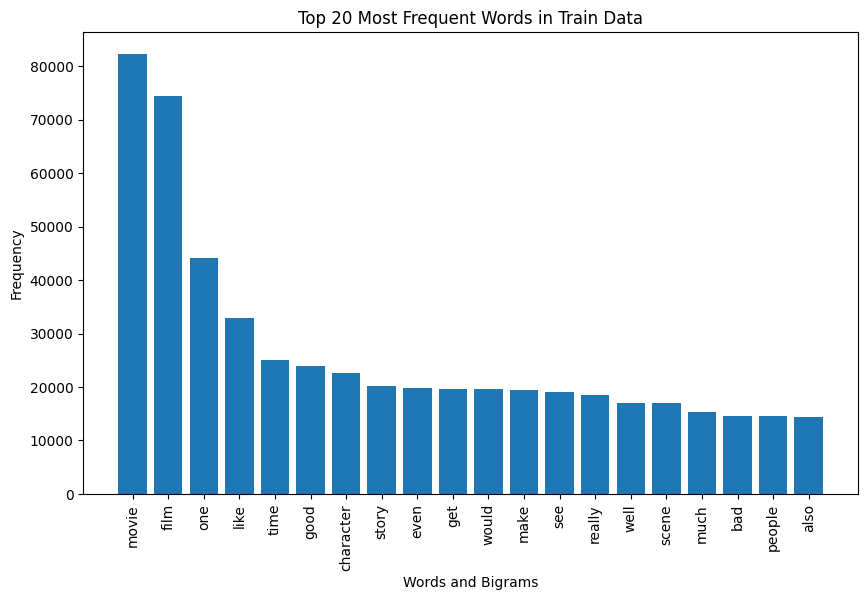

In [29]:
cv = CountVectorizer(ngram_range=(1, 1))
cv_train = cv.fit_transform(train_df.iloc[:, 0])

word_freq = pd.DataFrame(cv_train.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq.index[:20], word_freq.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words in Train Data')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()


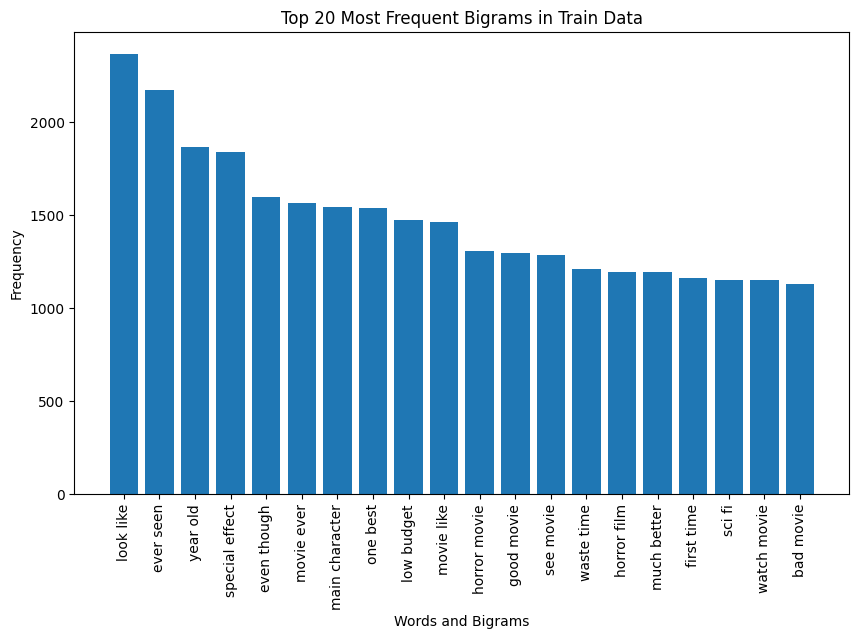

In [30]:
cv = CountVectorizer(ngram_range=(2, 2))
cv_train = cv.fit_transform(train_df.iloc[:, 0])

word_freq = pd.DataFrame(cv_train.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq.index[:20], word_freq.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Bigrams in Train Data')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

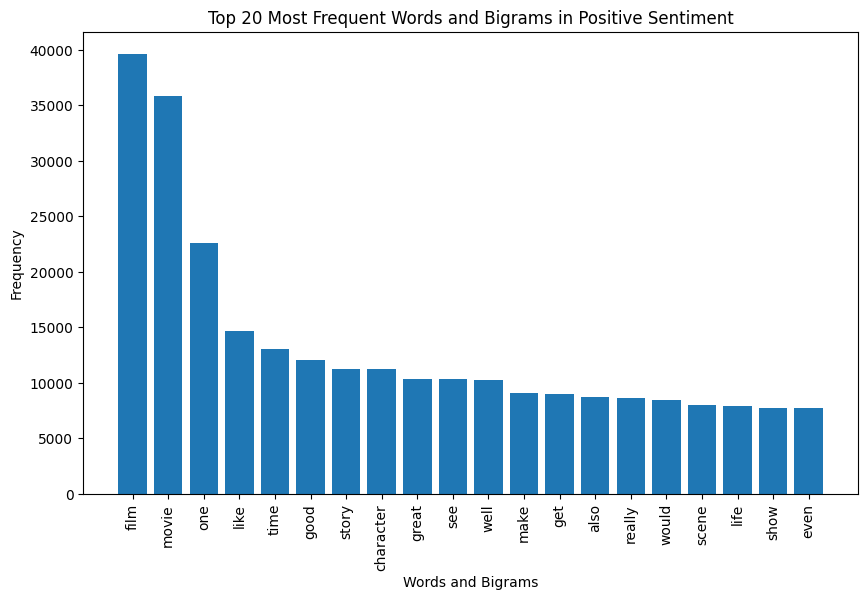

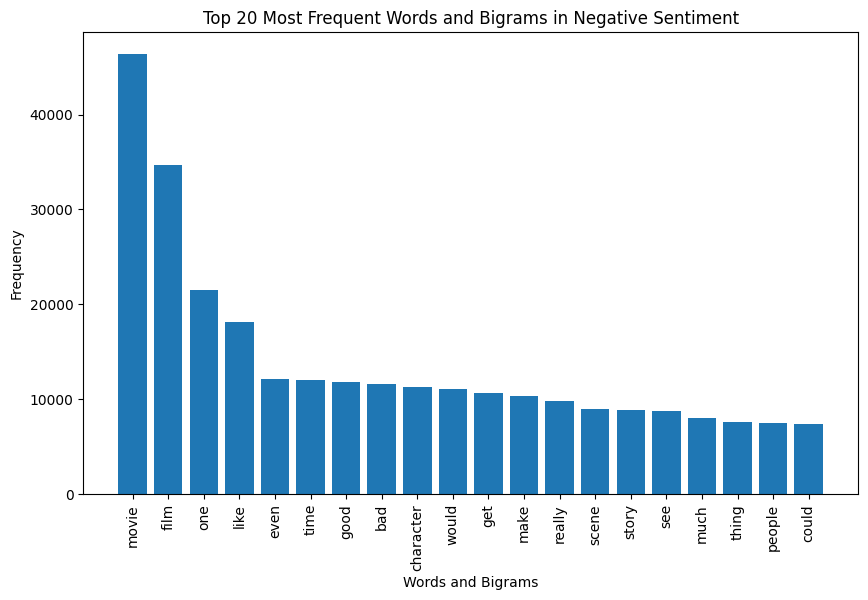

In [31]:
pos_df = train_df[train_df['label'] == 1]
neg_df = train_df[train_df['label'] == 0]

cv_pos = CountVectorizer(ngram_range=(1, 1))
cv_neg = CountVectorizer(ngram_range=(1, 1))
cv_train_pos = cv_pos.fit_transform(pos_df.iloc[:, 0])
cv_train_neg = cv_neg.fit_transform(neg_df.iloc[:, 0])

word_freq_pos = pd.DataFrame(cv_train_pos.sum(axis=0), columns=cv_pos.get_feature_names_out()).T.sort_values(by=0, ascending=False)
word_freq_neg = pd.DataFrame(cv_train_neg.sum(axis=0), columns=cv_neg.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq_pos.index[:20], word_freq_pos.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Positive Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(word_freq_neg.index[:20], word_freq_neg.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Negative Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()


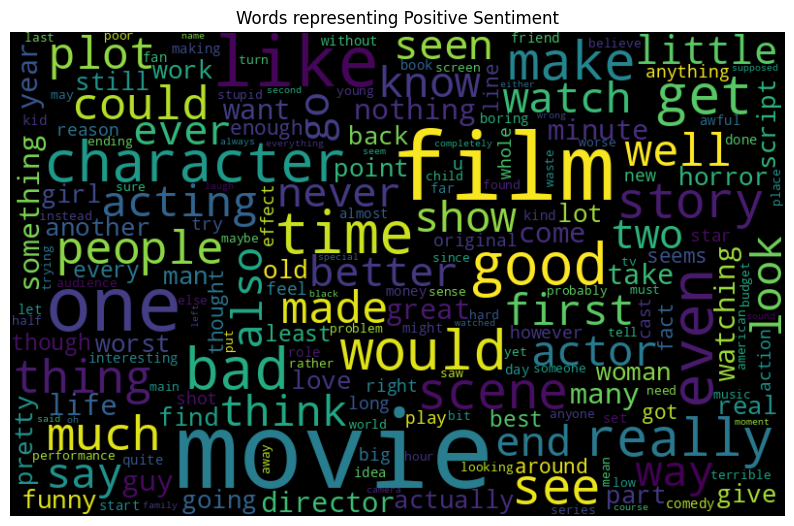

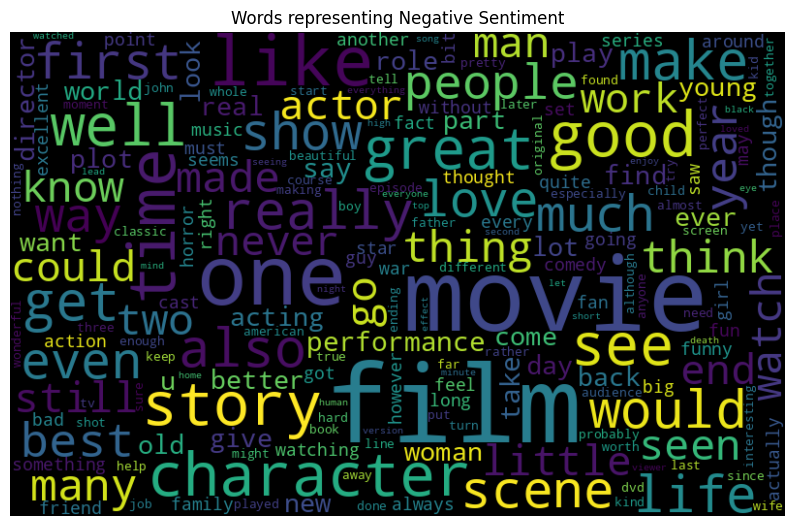

In [32]:
positive_text = train_df[train_df['label'] == 0]['text'].values
negative_text = train_df[train_df['label'] == 1]['text'].values

positive_freq = Counter(" ".join(positive_text).split())
negative_freq = Counter(" ".join(negative_text).split())

positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(positive_freq)
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(negative_freq)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words representing Positive Sentiment')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Words representing Negative Sentiment')
plt.show()


In [33]:
tokenizer.fit_on_texts(train_df.iloc[:, 0])
train_sequences = tokenizer.texts_to_sequences(train_df.iloc[:, 0])
train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [34]:
tokenizer.fit_on_texts(test_df.iloc[:, 0])
test_sequences = tokenizer.texts_to_sequences(test_df.iloc[:, 0])
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [35]:
tokenizer.fit_on_texts(val_df.iloc[:, 0])
val_sequences = tokenizer.texts_to_sequences(val_df.iloc[:, 0])
val_sequences = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


In [36]:
train_labels= pd.get_dummies(train_df['label']).values
test_labels= pd.get_dummies(test_df['label']).values
val_labels= pd.get_dummies(val_df['label']).values


## Q2)

In [43]:
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_6 (LSTM)               (None, 200, 64)           49408     
                                                                 
 batch_normalization_8 (Batc  (None, 200, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 200, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                      

2023-10-11 10:02:12.222080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:02:12.223083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:02:12.223722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [44]:
lstm_hist = lstm_model.fit(train_sequences, train_labels, epochs=3, validation_data=(val_sequences, val_labels))


Epoch 1/3


2023-10-11 10:02:15.824230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:02:15.825166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:02:15.826070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1242/1242 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.5045

2023-10-11 10:02:46.890878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:02:46.891598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:02:46.892369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1242/1242 [==============================] - 33s 25ms/step - loss: 0.8180 - accuracy: 0.5045 - val_loss: 0.7262 - val_accuracy: 0.5054
Epoch 2/3
1242/1242 [==============================] - 31s 25ms/step - loss: 0.5179 - accuracy: 0.7399 - val_loss: 1.0505 - val_accuracy: 0.6741
Epoch 3/3
1242/1242 [==============================] - 31s 25ms/step - loss: 0.2878 - accuracy: 0.8915 - val_loss: 0.7290 - val_accuracy: 0.6701


In [45]:
gru_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    GRU(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GRU(64),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
gru_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
gru_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 gru_2 (GRU)                 (None, 200, 64)           37248     
                                                                 
 batch_normalization_10 (Bat  (None, 200, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 200, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                     

2023-10-11 10:03:50.575330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:03:50.575927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:03:50.576628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
gru_hist = gru_model.fit(train_sequences, train_labels, epochs=3, validation_data=(val_sequences, val_labels))


Epoch 1/3


2023-10-11 10:03:50.829161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:03:50.830269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:03:50.831036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1241/1242 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.5009

2023-10-11 10:04:19.644425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:04:19.645277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:04:19.646115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1242/1242 [==============================] - 31s 24ms/step - loss: 0.8899 - accuracy: 0.5009 - val_loss: 0.7020 - val_accuracy: 0.5084
Epoch 2/3
1242/1242 [==============================] - 29s 23ms/step - loss: 0.8087 - accuracy: 0.5078 - val_loss: 0.7055 - val_accuracy: 0.5036
Epoch 3/3
1242/1242 [==============================] - 29s 23ms/step - loss: 0.7630 - accuracy: 0.5219 - val_loss: 0.7698 - val_accuracy: 0.5014


In [47]:
bid_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
bid_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
bid_model.summary()


2023-10-11 10:05:19.423260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:05:19.424322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:05:19.424953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 batch_normalization_12 (Bat  (None, 200, 128)         512       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         98816     
 nal)                                                            
                                                      

2023-10-11 10:05:19.888259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-10-11 10:05:19.912781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:05:19.913439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [48]:
bid_hist = bid_model.fit(train_sequences, train_labels, epochs=3, validation_data=(val_sequences, val_labels))


Epoch 1/3


2023-10-11 10:05:20.102931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:05:20.104255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:05:20.105097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1242/1242 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.6798

2023-10-11 10:06:33.834546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:06:33.835692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:06:33.836485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1242/1242 [==============================] - 78s 60ms/step - loss: 0.7126 - accuracy: 0.6798 - val_loss: 0.8177 - val_accuracy: 0.6735
Epoch 2/3
1242/1242 [==============================] - 73s 59ms/step - loss: 0.3526 - accuracy: 0.8731 - val_loss: 1.0816 - val_accuracy: 0.6234
Epoch 3/3
1242/1242 [==============================] - 73s 58ms/step - loss: 0.2768 - accuracy: 0.9018 - val_loss: 0.9000 - val_accuracy: 0.6495


## Q3)

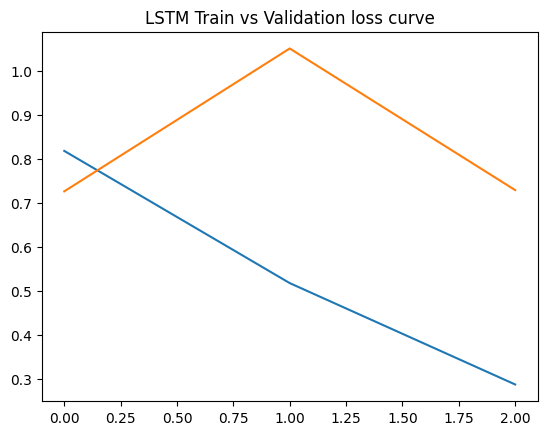

In [49]:
plt.title("LSTM Train vs Validation loss curve")
plt.plot(range(3), lstm_hist.history["loss"])
plt.plot(range(3), lstm_hist.history["val_loss"])


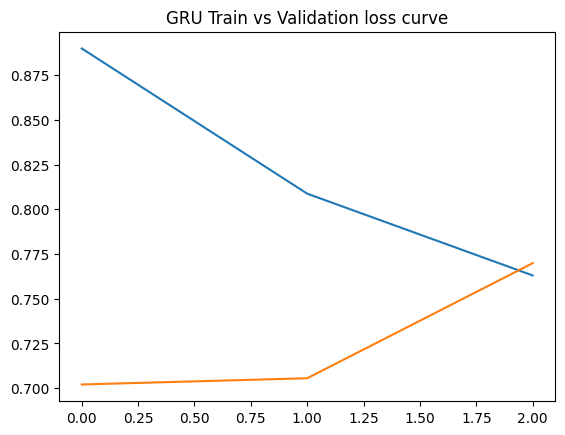

In [50]:
plt.title("GRU Train vs Validation loss curve")
plt.plot(range(3), gru_hist.history["loss"])
plt.plot(range(3), gru_hist.history["val_loss"])


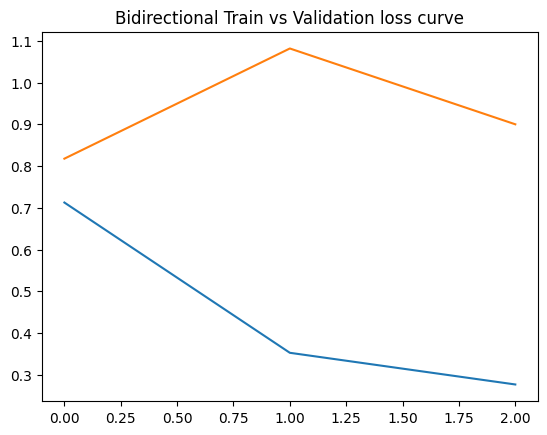

In [51]:
plt.title("Bidirectional Train vs Validation loss curve")
plt.plot(range(3), bid_hist.history["loss"])
plt.plot(range(3), bid_hist.history["val_loss"])

## Q4)

In [52]:
data = {
    'text': [
        'An outstanding masterpiece with excellent performances.',
        'A timeless classic that never fails to impress.',
        'A thrilling experience with a memorable villain.',
        'A unique and unconventional film that\'s not for everyone.',
        'A disaster of a movie that\'s so bad it\'s good.',
        'A beautiful love story that will bring you to tears.',
        'A lackluster film with a weak plot and poor character development.',
        'An epic conclusion to the Marvel Cinematic Universe saga.',
        'A bizarre and confusing adaptation that misses the mark.',
        'A brilliant social commentary with unexpected twists and turns.'
    ],
    'label': [1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
}

df = pd.DataFrame(data)
df


,text,label
0,An outstanding masterpiece with excellent perf...,1
1,A timeless classic that never fails to impress.,1
2,A thrilling experience with a memorable villain.,1
3,A unique and unconventional film that's not fo...,0
4,A disaster of a movie that's so bad it's good.,0
5,A beautiful love story that will bring you to ...,1
6,A lackluster film with a weak plot and poor ch...,0
7,An epic conclusion to the Marvel Cinematic Uni...,1
8,A bizarre and confusing adaptation that misses...,0
9,A brilliant social commentary with unexpected ...,1


In [53]:
tokenizer.fit_on_texts(df.iloc[:, 0])
test_sequences = tokenizer.texts_to_sequences(df.iloc[:, 0])
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

test_labels = df['label']


In [54]:
predictions = lstm_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]

correct_predictions = sum([predicted_labels[i] == test_labels[i] for i in range(len(test_labels))])

lstm_accuracy = correct_predictions / len(test_labels)
lstm_accuracy


2023-10-11 10:09:48.091663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:09:48.092385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:09:48.093327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 355ms/step


0.6

In [55]:
predictions = gru_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]

correct_predictions = sum([predicted_labels[i] == test_labels[i] for i in range(len(test_labels))])

gru_accuracy = correct_predictions / len(test_labels)
gru_accuracy


2023-10-11 10:10:00.167291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:10:00.168126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:10:00.168924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 304ms/step


0.6

In [56]:
predictions = bid_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]

correct_predictions = sum([predicted_labels[i] == test_labels[i] for i in range(len(test_labels))])

bid_accuracy = correct_predictions / len(test_labels)
bid_accuracy


2023-10-11 10:10:04.930512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 10:10:04.931288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 10:10:04.932296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


0.5